# 1. Fitting Ne lines in a loop
- This is the first step of fitting Diad data
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)
- Uncomment this line if you havent installed DiadFit, or are running a much older version. 

In [1]:
#!pip install --upgrade DiadFit

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
# This needs to be 0.0.68 or higher!
pf.__version__

'0.0.88'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [3]:
import os
DayFolder=os.getcwd()
meta_path=DayFolder +  '\MetaData'
spectra_path=DayFolder + '\Spectra'
# Filetype and extension for spectra
spectra_filetype='headless_txt'
spectra_file_ext='.txt'
# file extension for spectra
meta_file_ext='.txt'
# Does your file start with a prefix? E.g 01 Ne_line.txt?
prefix=True
# If so - what is the character separating the prefix from the real name
prefix_str=' '
# Does your instrument have TruPower (WITEC)
TruPower=True
# Save settings to a file to use in all other notebooks
pf.save_settings(meta_path, spectra_path, spectra_filetype, prefix, prefix_str, spectra_file_ext, meta_file_ext, TruPower)


Good job! Filetype headless_txt is valid.


In [4]:
# This step gets all your Ne files. Enter ID_str as a string in only your Neon files, exclude strings not in Ne files. So here we take files with 'Ne' in the name and exclude those with 'diad' in the name. 
Ne_files=pf.get_files(path=spectra_path,
file_ext=spectra_file_ext, ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files

['01 Ne--Spectrum--000--Spec.Data 1.txt',
 '02 Ne--Spectrum--001--Spec.Data 1.txt',
 '03 Ne--Spectrum--002--Spec.Data 1.txt',
 '07 Ne--Spectrum--023--Spec.Data 1.txt',
 '12 Ne--Spectrum--036--Spec.Data 1.txt',
 '18 Ne--Spectrum--058--Spec.Data 1.txt',
 '19 Ne--Spectrum--059--Spec.Data 1.txt',
 '25 Ne--Spectrum--075--Spec.Data 1.txt',
 '27 Ne--Spectrum--085--Spec.Data 1.txt',
 '33 Ne--Spectrum--108--Spec.Data 1.txt',
 '34 Ne--Spectrum--109--Spec.Data 1.txt',
 '35 Ne--Spectrum--110--Spec.Data 1.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [5]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.head()

Raman_shift (cm-1)  Intensity  Ne emission line in air
3           391.536362     2500.0                543.36513
15          818.699523     5000.0                556.27662
23         1117.086987     5000.0                565.66588
30         1310.480205     5000.0                571.92248
33         1398.915133     5000.0                574.82985

### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [6]:
line_1=1117
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=2000)
ideal_split

Ne_Split       Line_1       Line_2  Line_1_int  Line_2_int  \
0  330.477634  1117.086987  1447.564622      5000.0      7000.0   

   Entered Pos Line 1  Entered Pos Line 2  
0                1117                1447

## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [7]:
i=0 # Select one file
filename=Ne_files[i] 
print(filename)

01 Ne--Spectrum--000--Spec.Data 1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

Peak1_cent  Peak1_height   Peak2_cent  Peak2_height   Peak1_prom  \
0  1116.16583        5644.0  1447.138537   42445.33203  4923.499982   

     Peak2_prom  
0  41724.832012

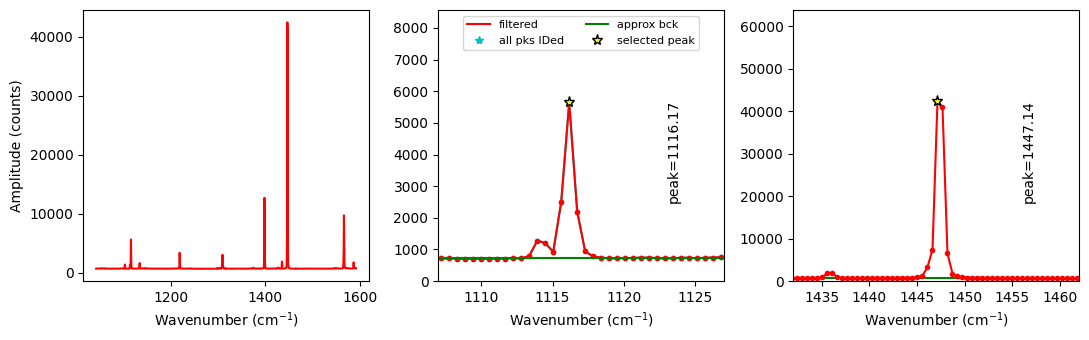

In [8]:
exclude_range_1=None
exclude_range_2=None

Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=spectra_filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [9]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, peaks_2=1, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), LH_offset_mini2=None, x_span_pk1=None, x_span_pk2=None)

In [10]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=2, LH_offset_mini=[0.5, 3],
pk1_sigma=0.6, pk2_sigma=0.3,
lower_bck_pk1=(-40, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
N_poly_pk2_baseline=2 )

filename  1σ_Ne_Corr_test  1σ_Ne_Corr  \
0  Ne--Spectrum--000--Spec.Data 1.txt         0.000035    0.000035   

   pk2_peak_cent  pk2_amplitude  pk2_sigma pk2_gamma  error_pk2  \
0    1447.391863   54745.569902   0.402531      None   0.001324   

   Peak2_Prop_Lor  pk1_peak_cent  ...  Peak1_Prop_Lor     deltaNe   Ne_Corr  \
0        0.384915    1116.140656  ...        0.316371  331.251207  0.997665   

   Ne_Corr_min  Ne_Corr_max  residual_pk2  residual_pk1  residual_pk1+pk2  \
0     0.997626     0.997703    125.992348     14.676471        140.668819   

   error_pk1_amplitude  error_pk2_amplitude  
0           195.890185           431.943211  

[1 rows x 24 columns]

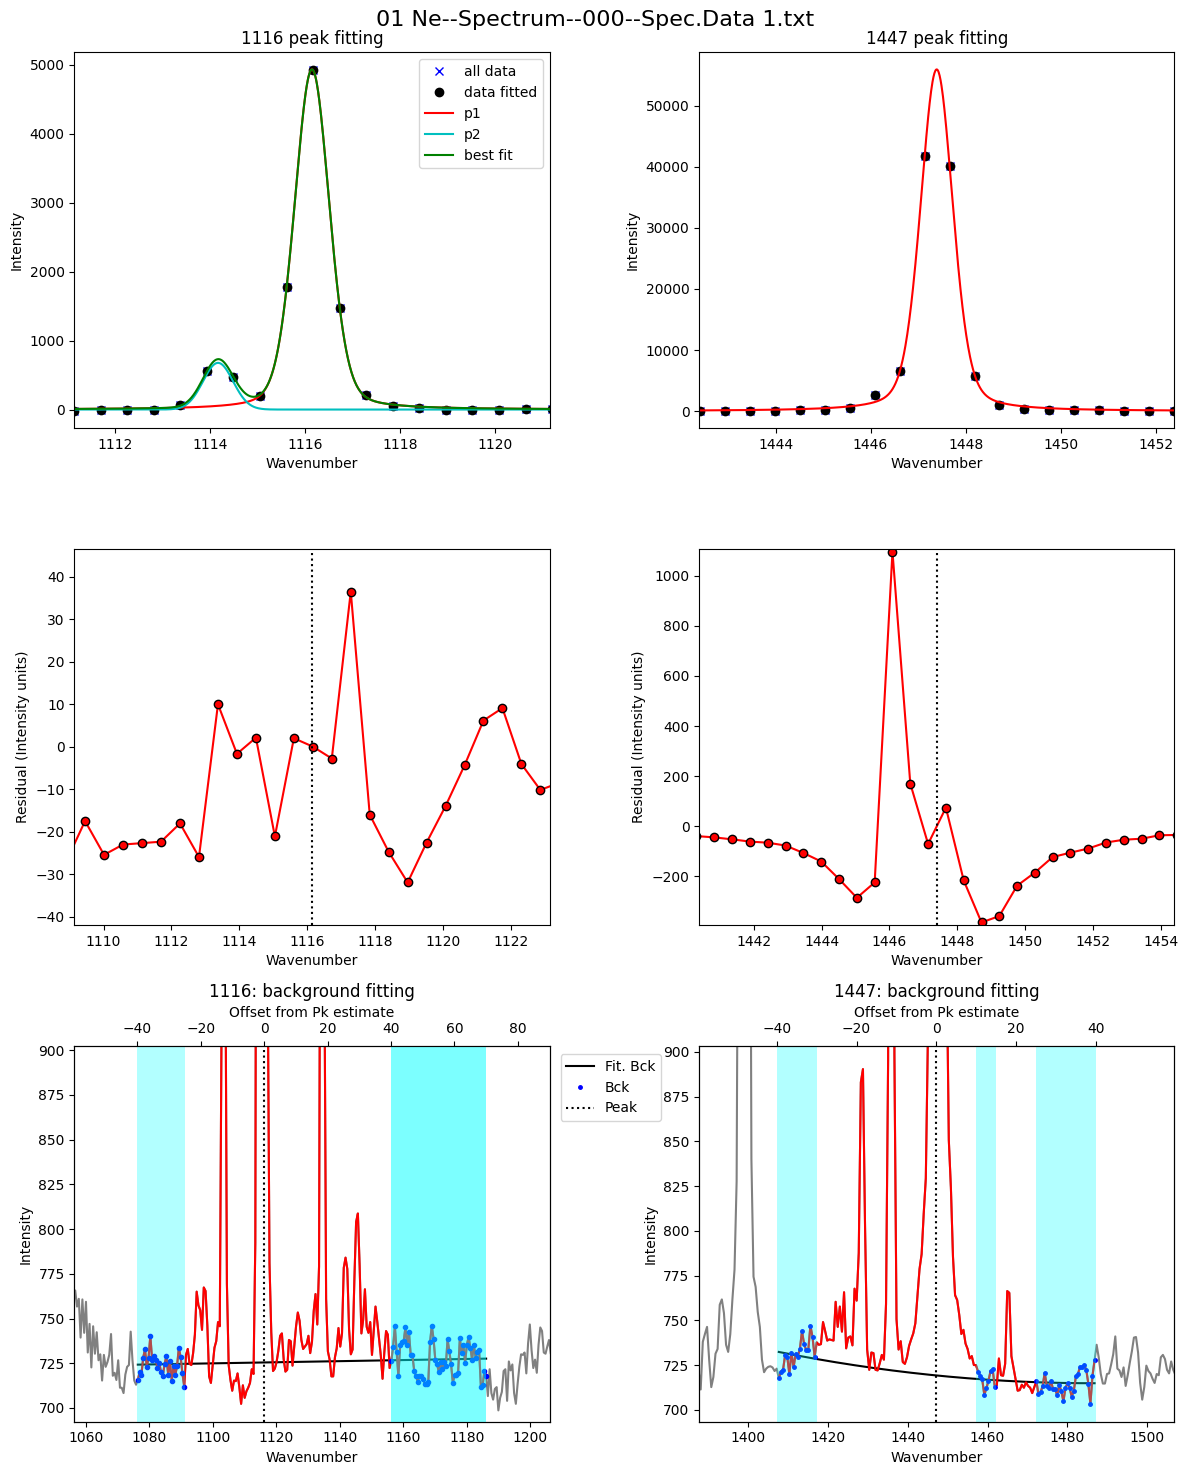

In [11]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=prefix,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[0], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[0],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[0],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[0],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [12]:
## Now tweak the values of the sigma to help with the looping - then for looping we let these parameters only vary +-20% between spectra
Ne_Config_est.pk1_sigma=df_test_params['pk1_sigma'][0]
Ne_Config_est.pk2_sigma=df_test_params['pk2_sigma'][0]


## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

  0%|          | 0/12 [00:00<?, ?it/s]

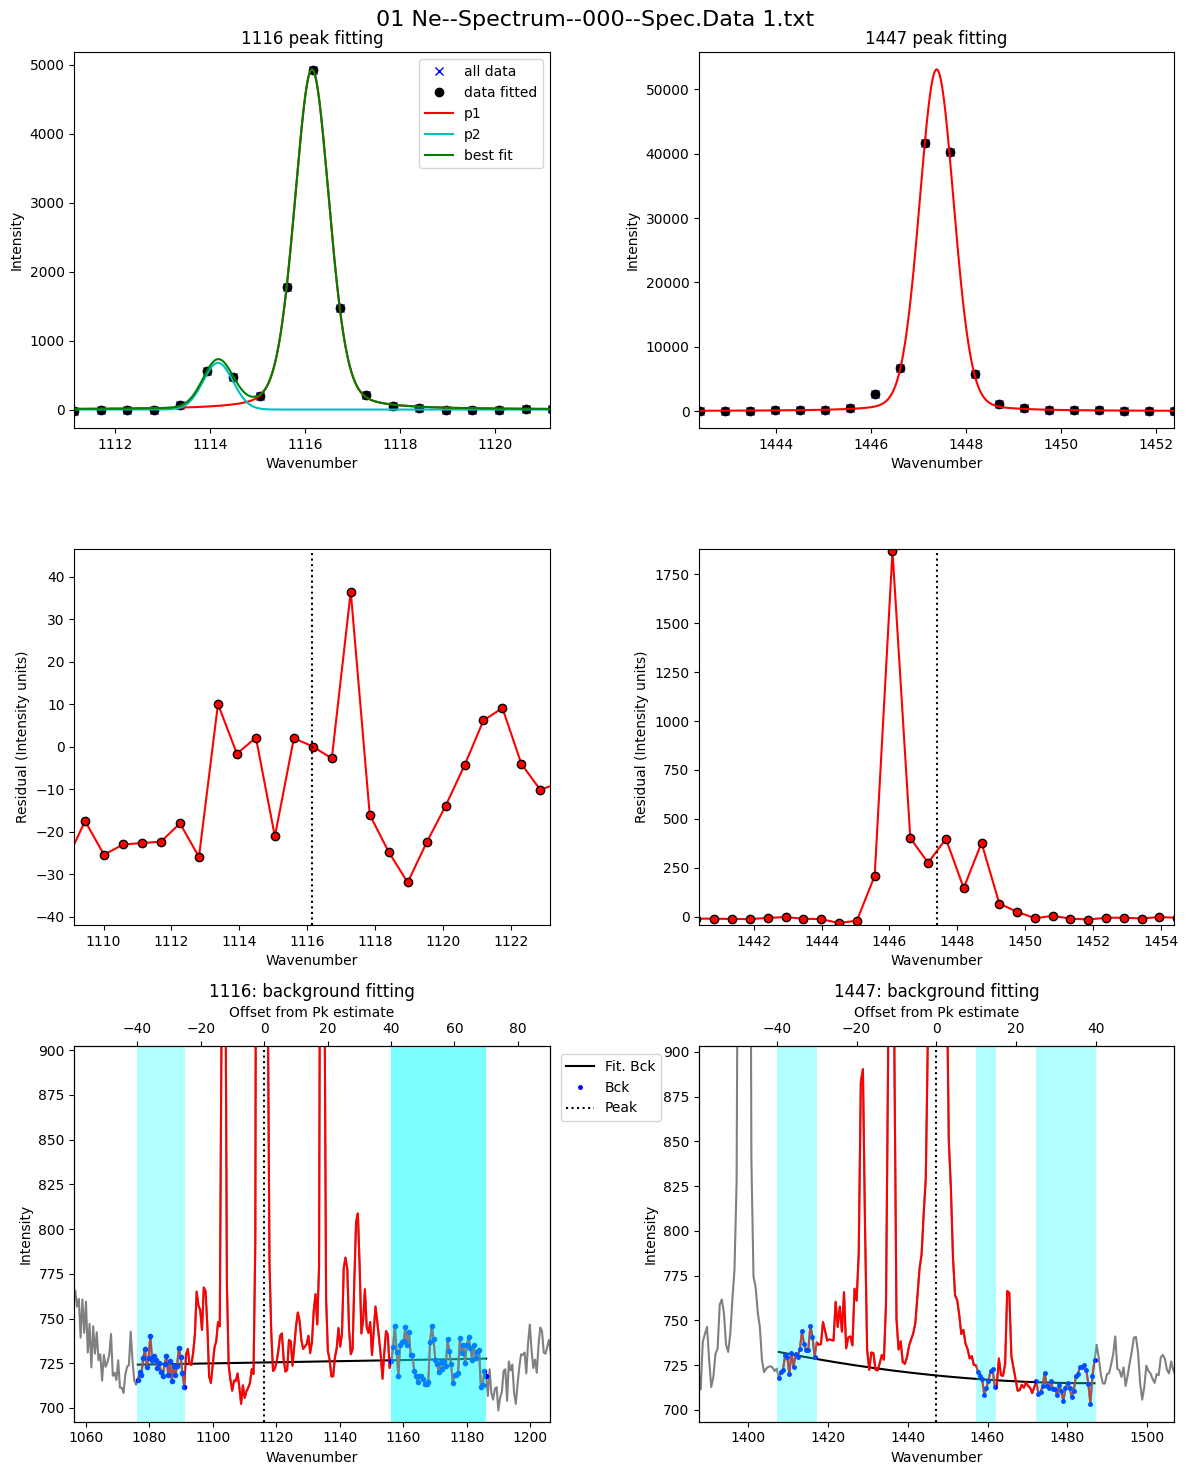

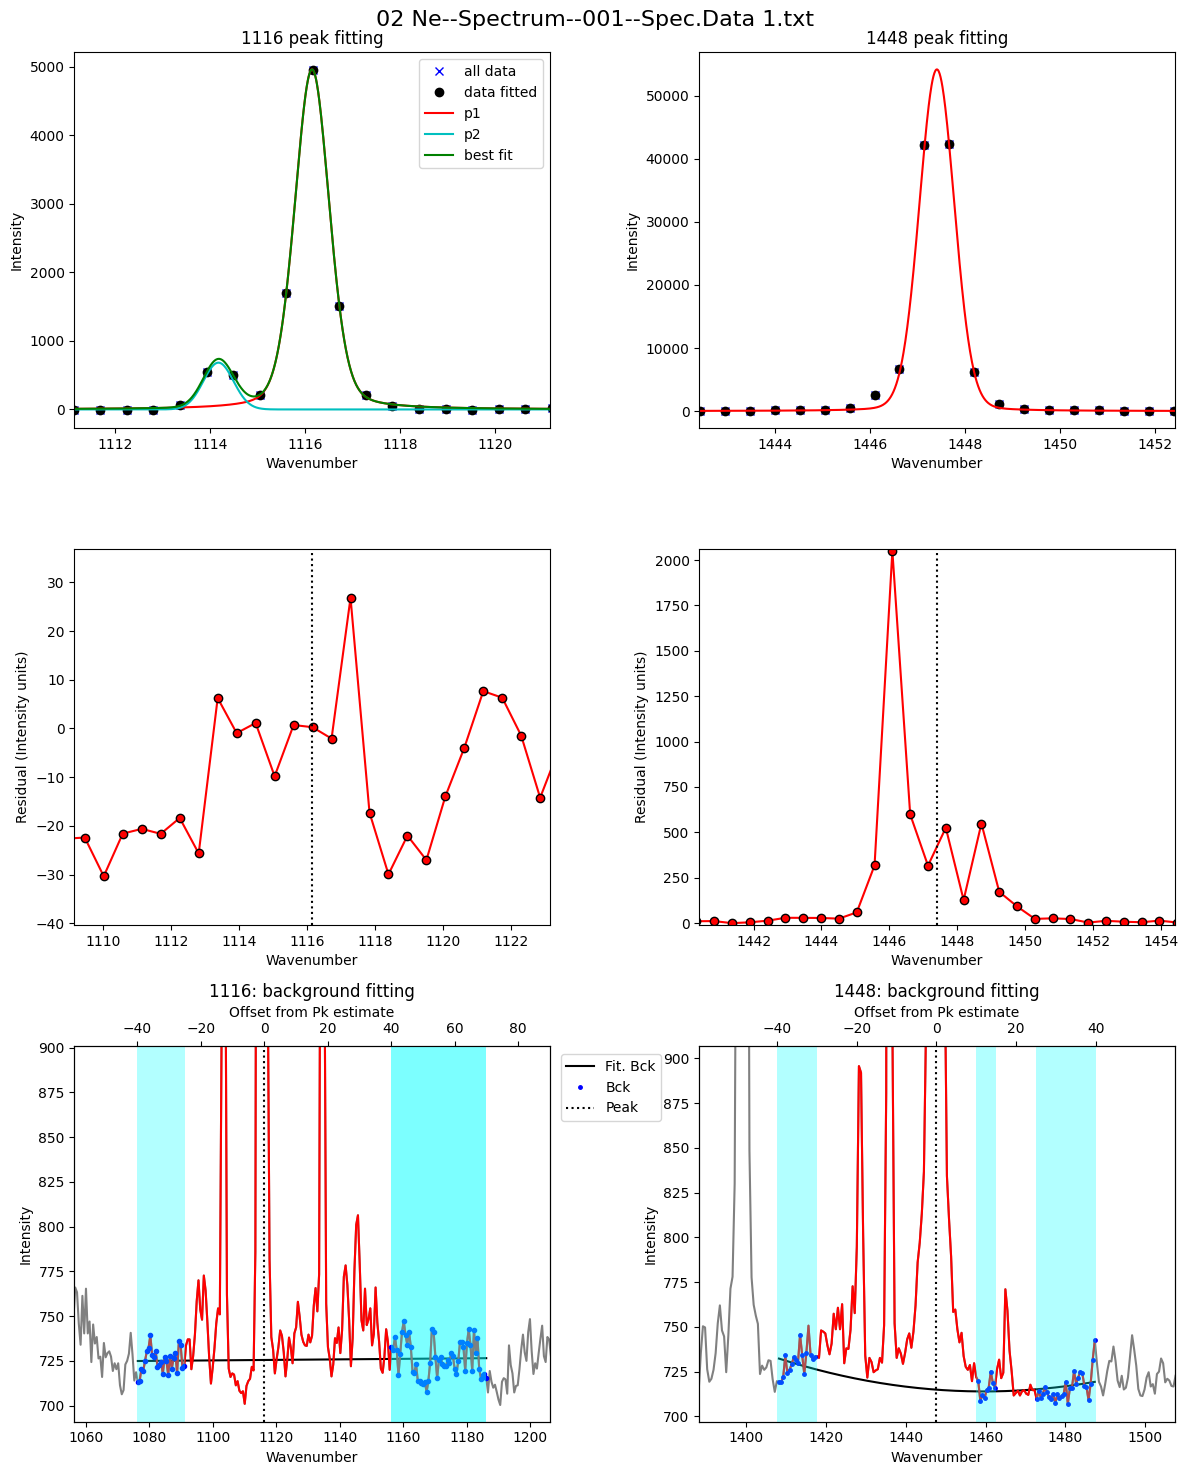

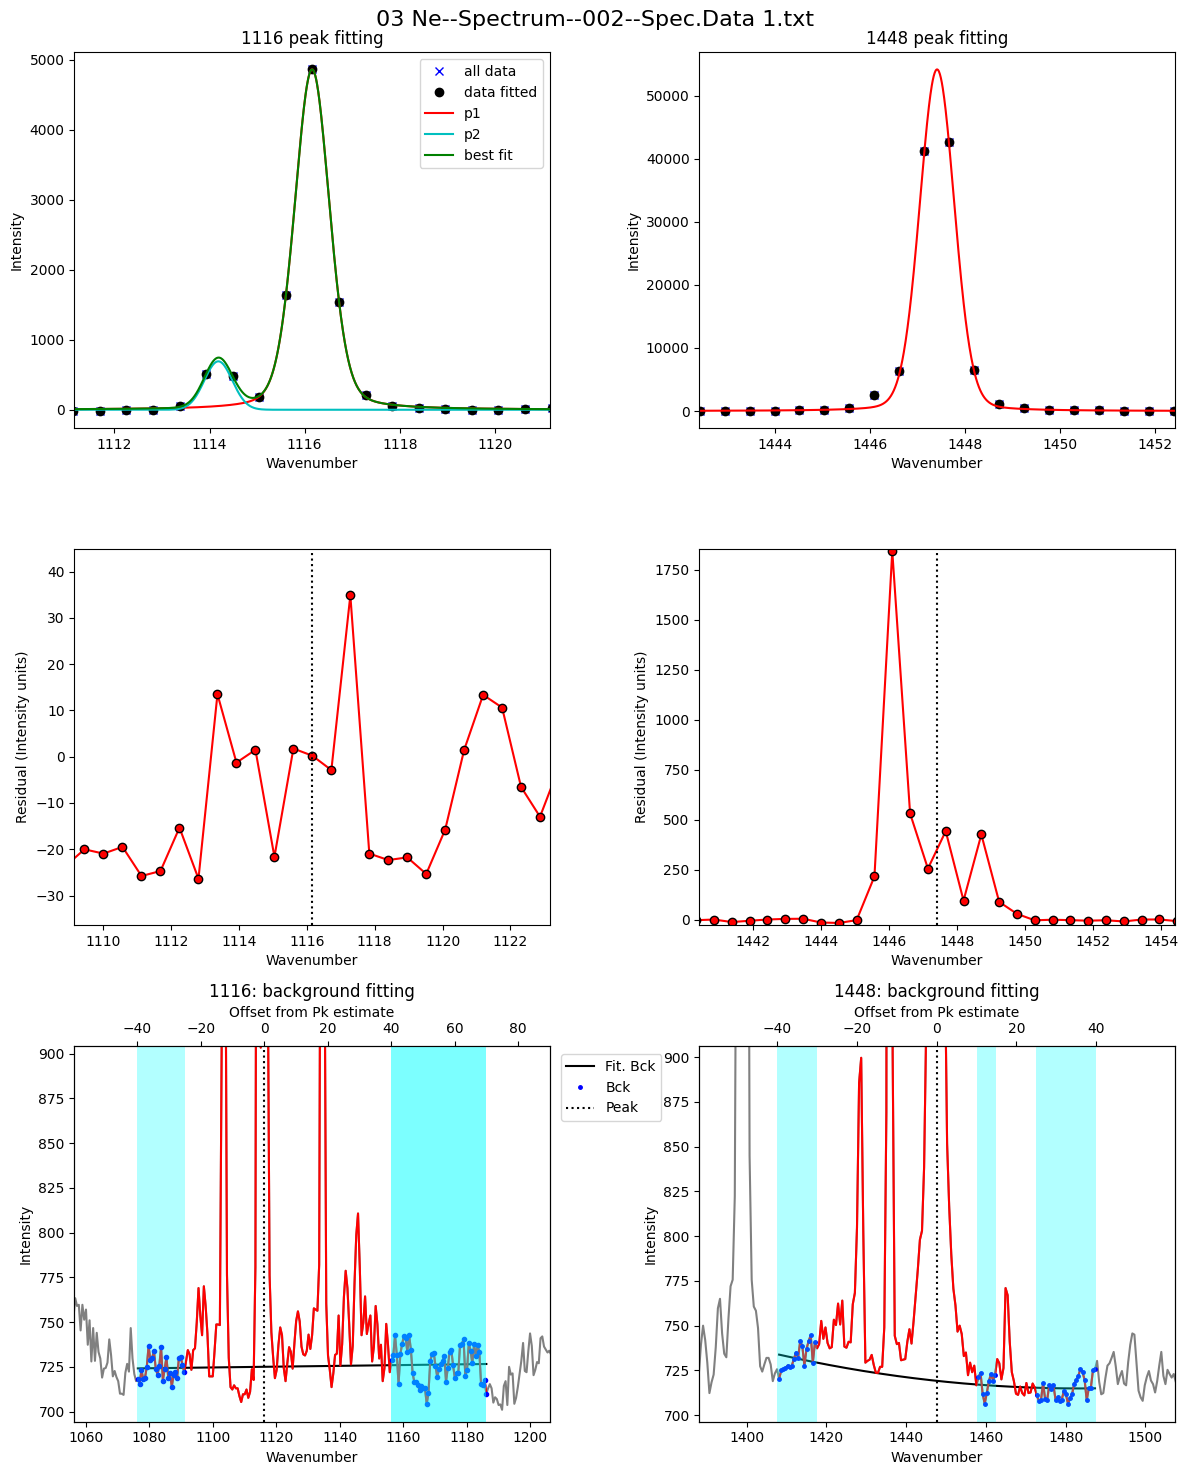

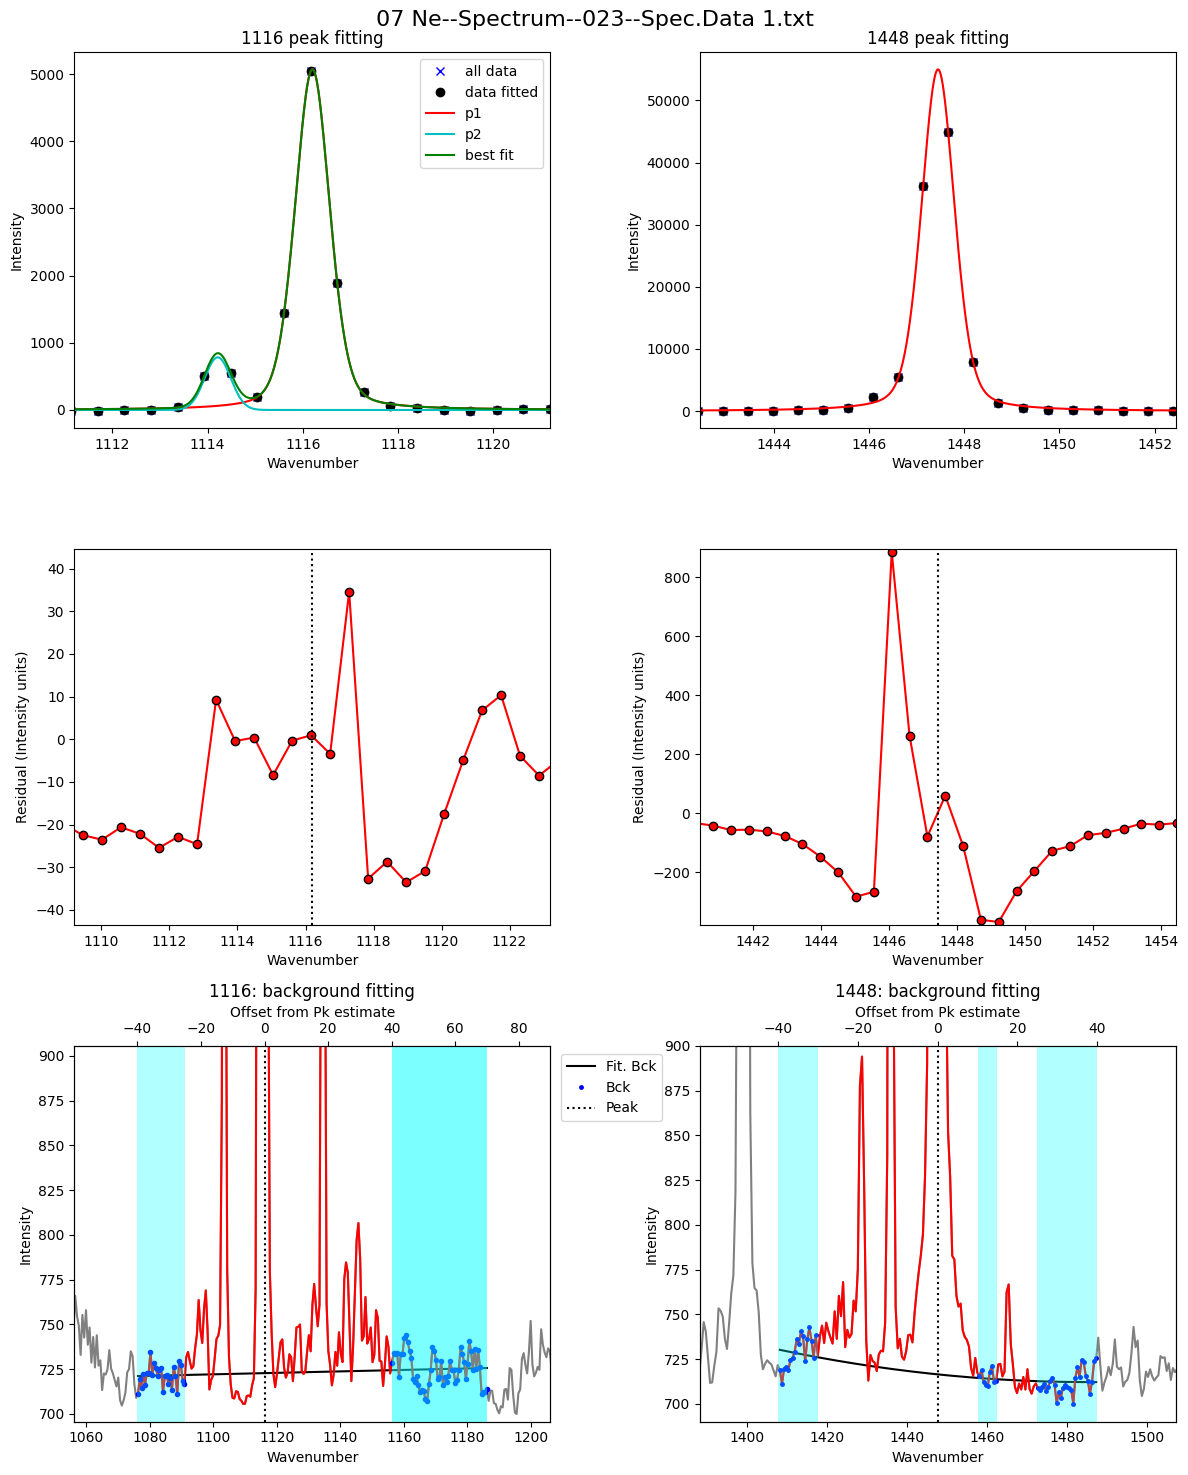

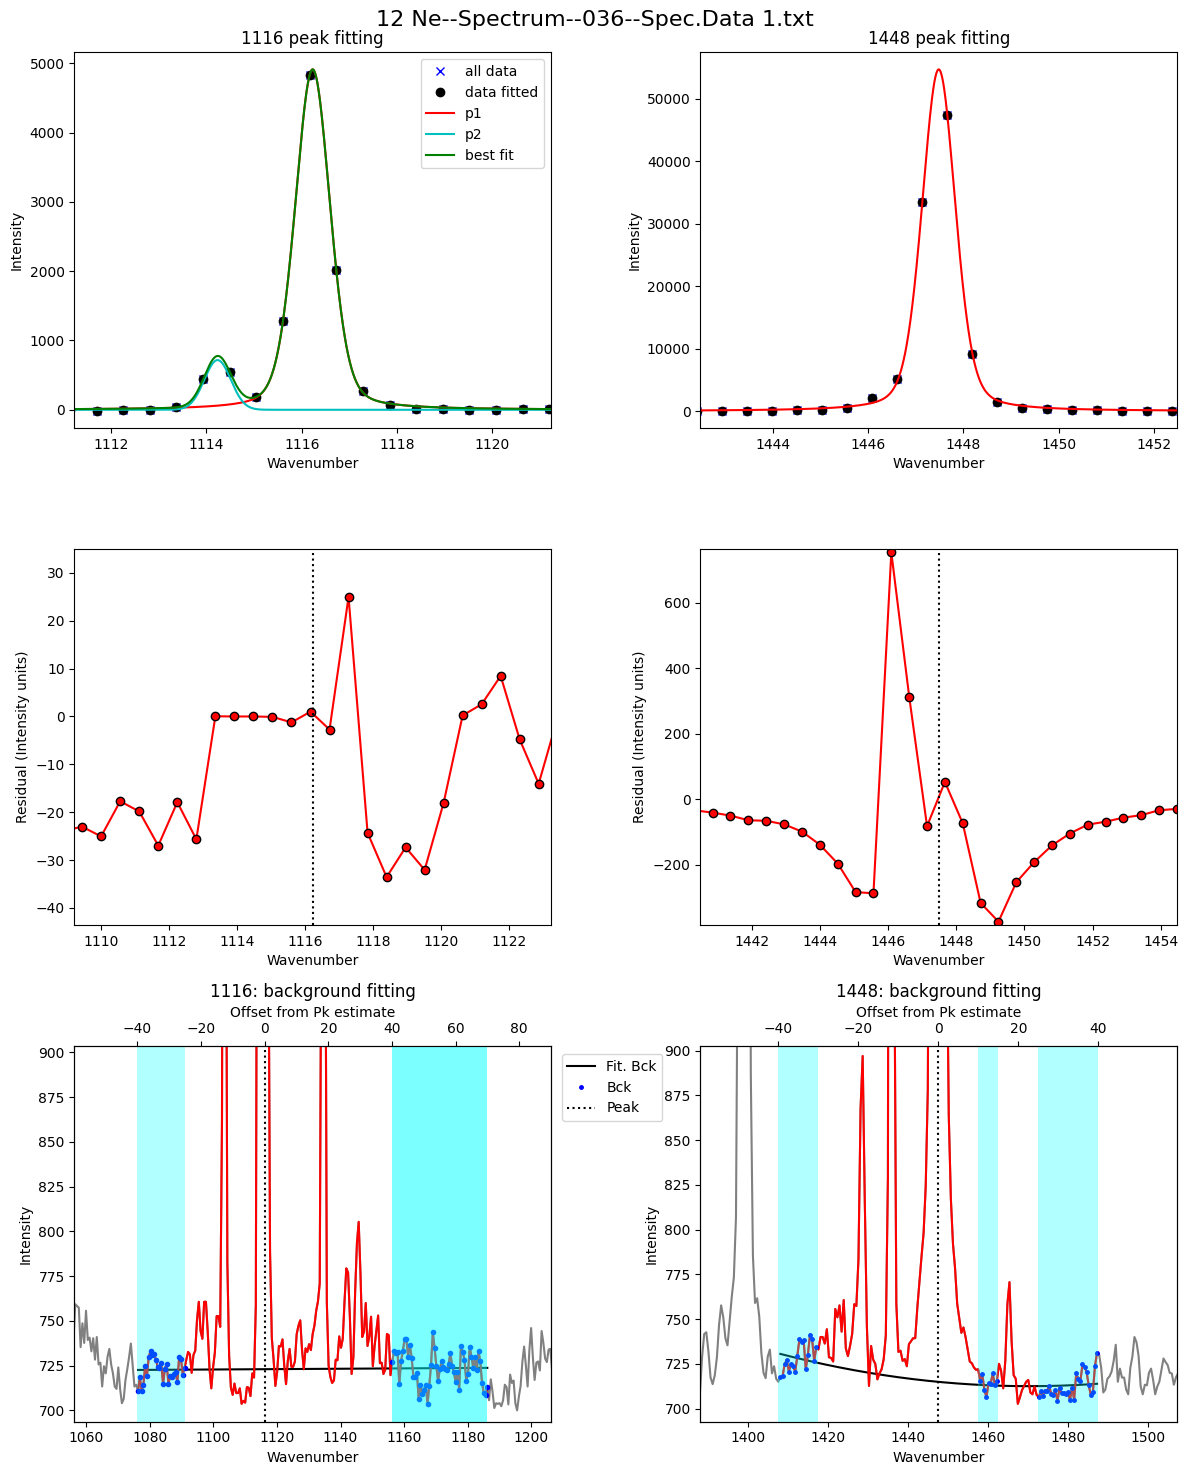

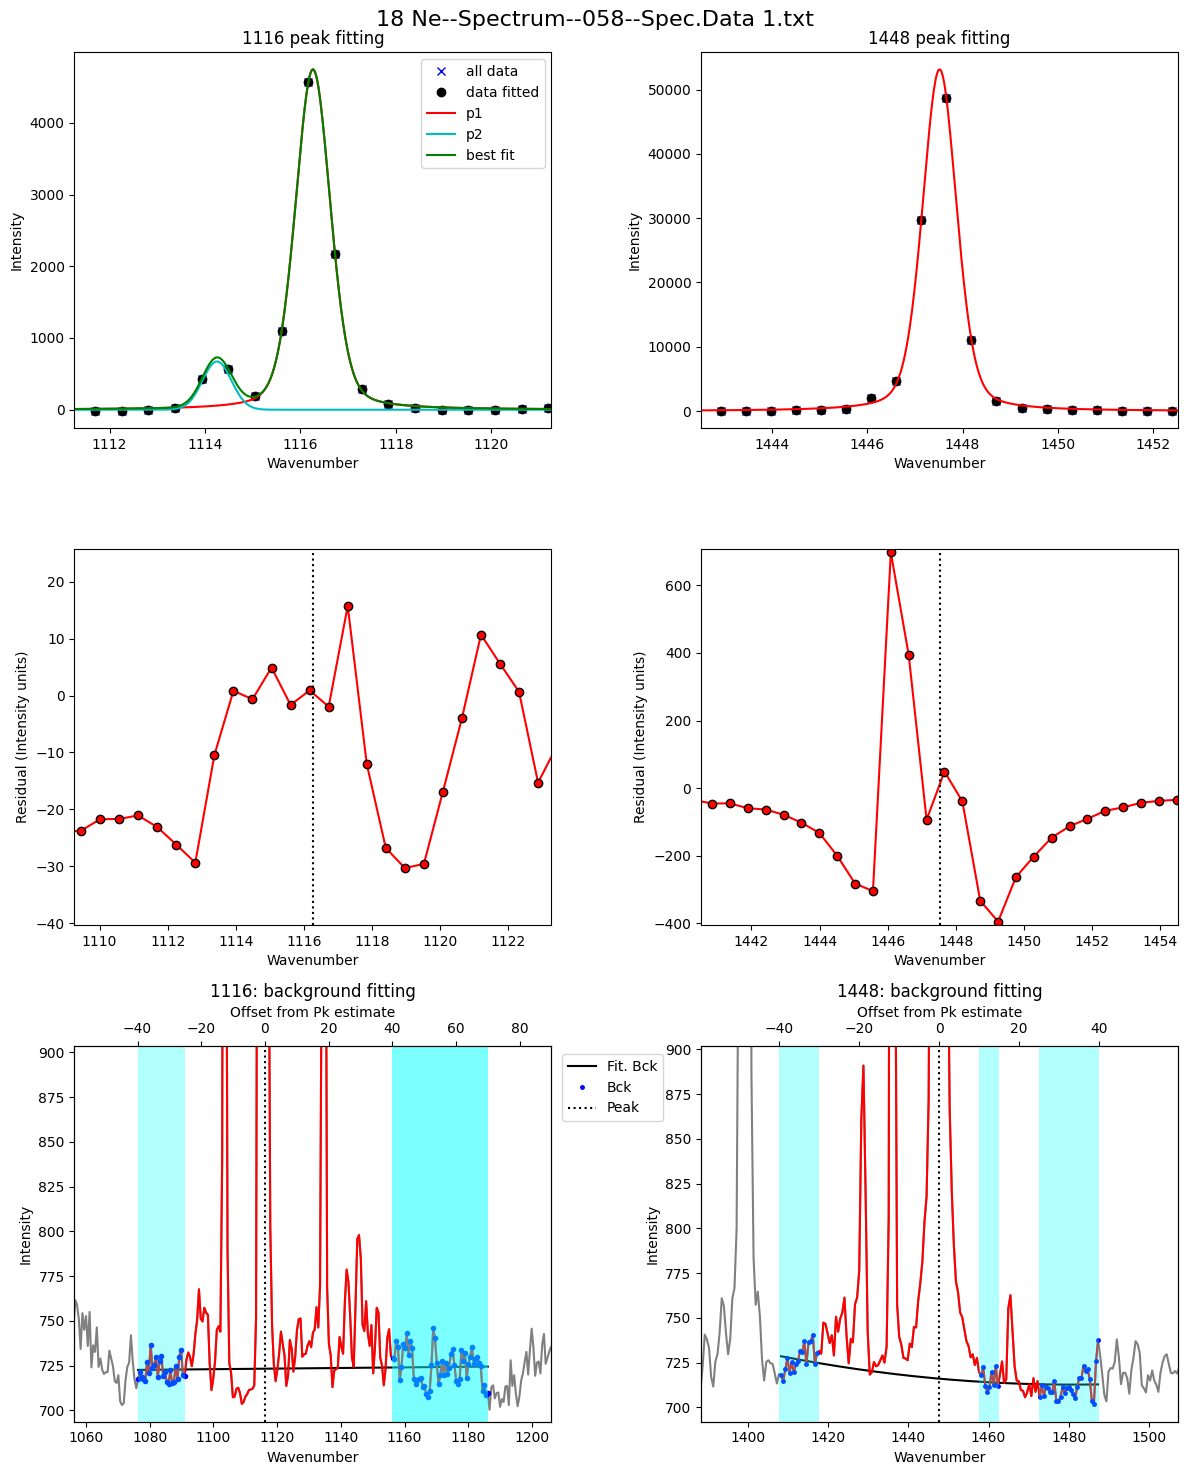

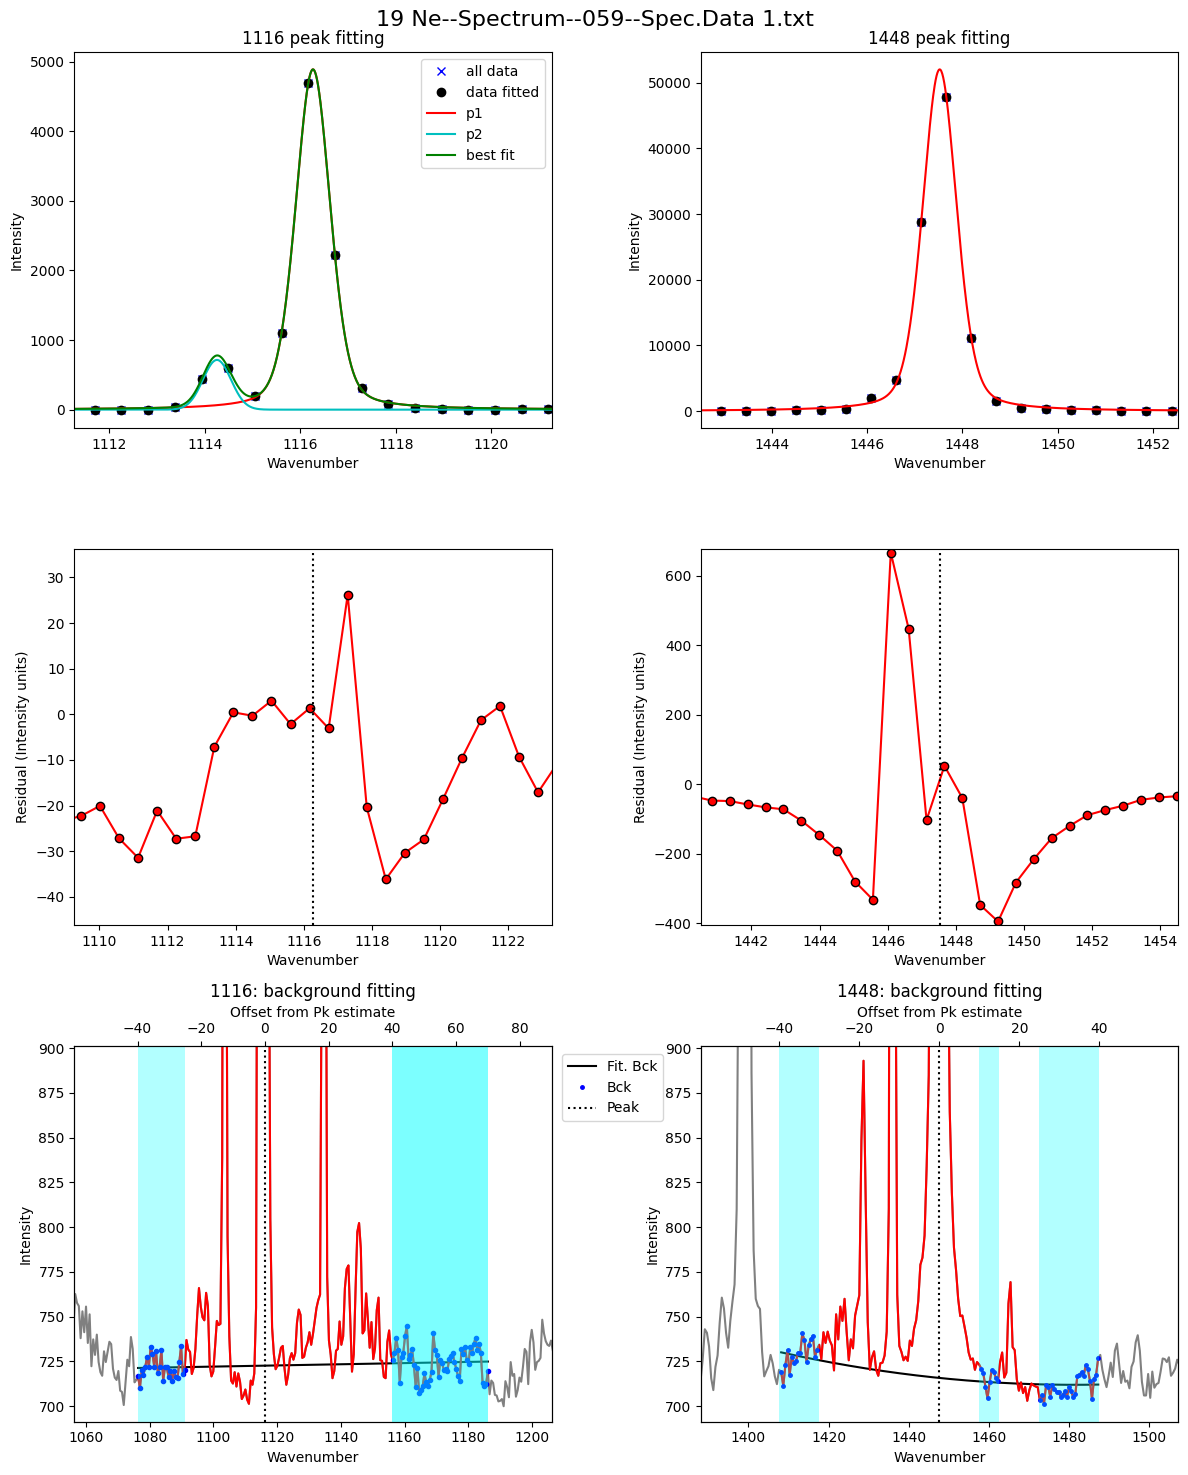

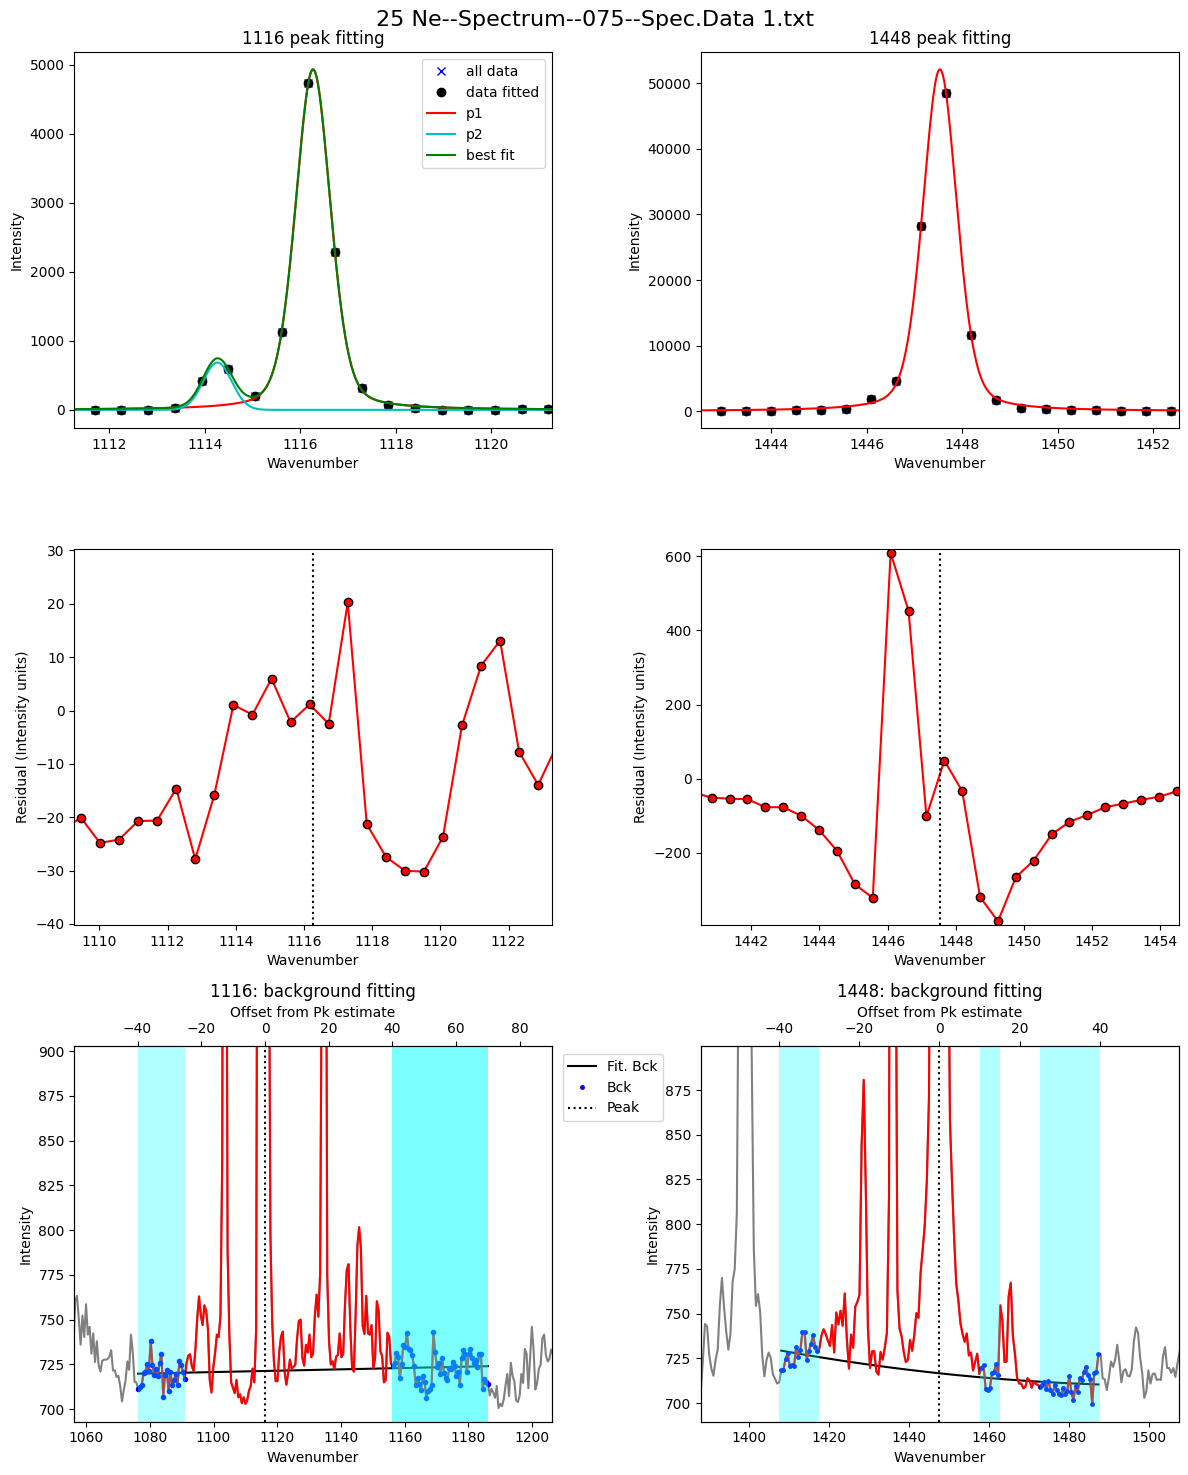

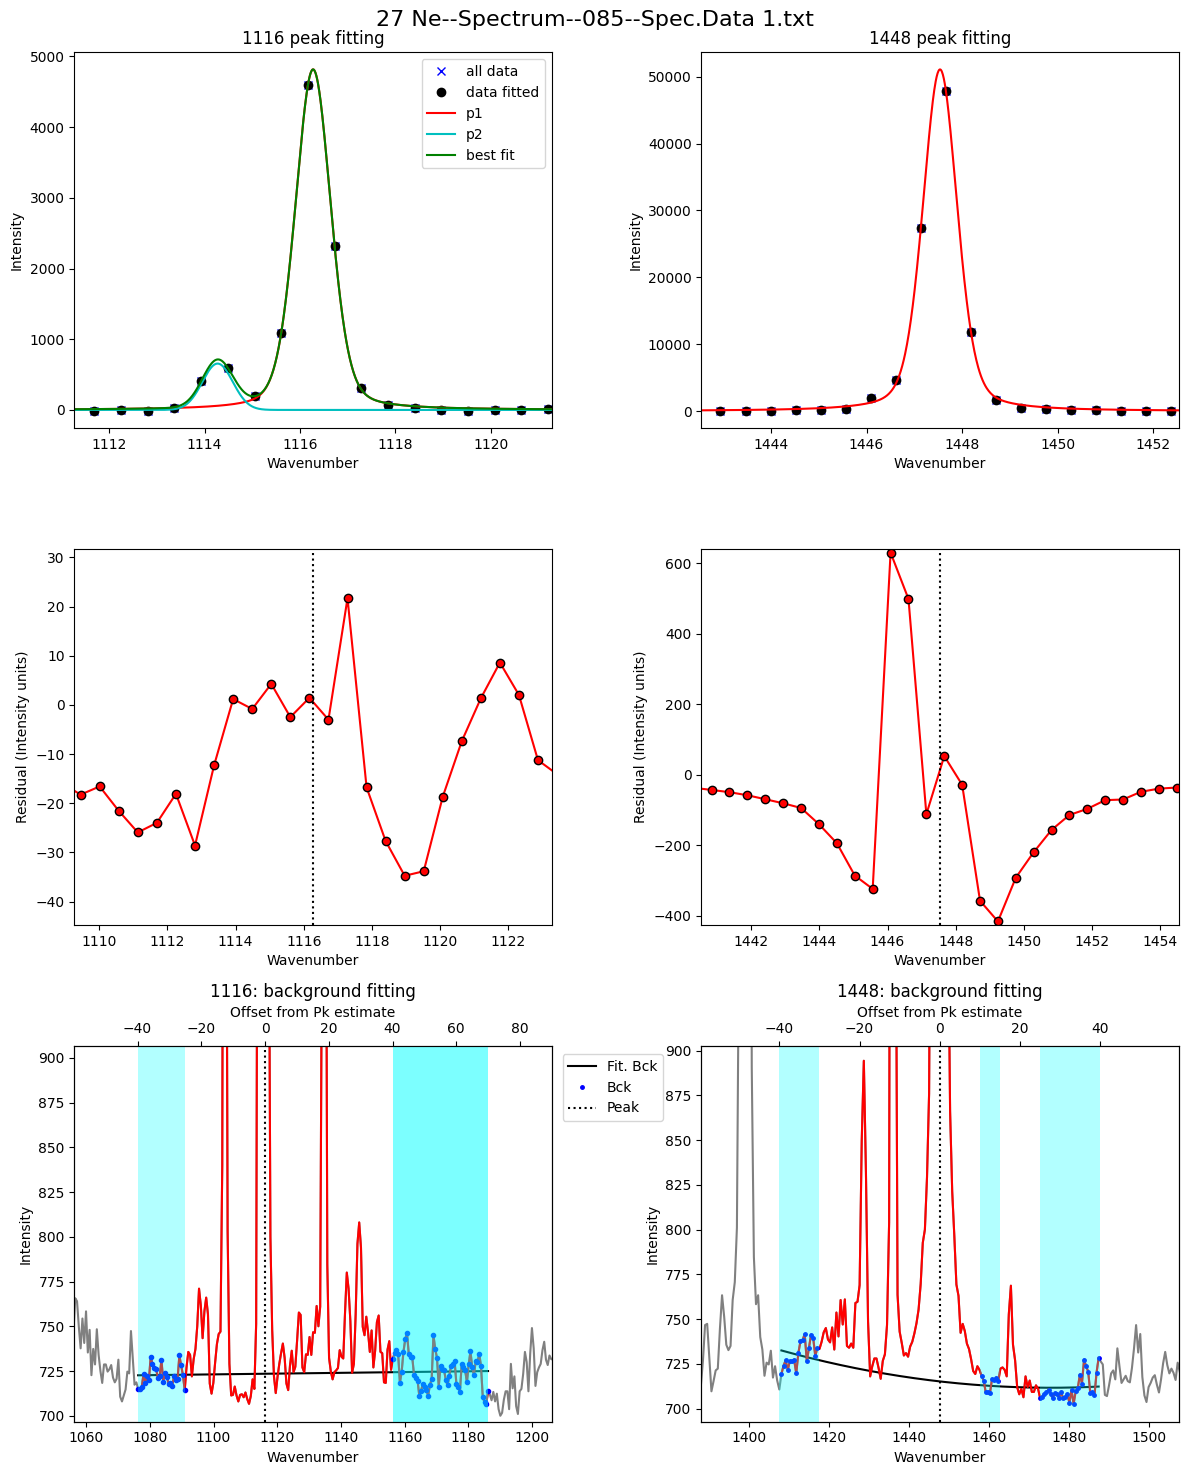

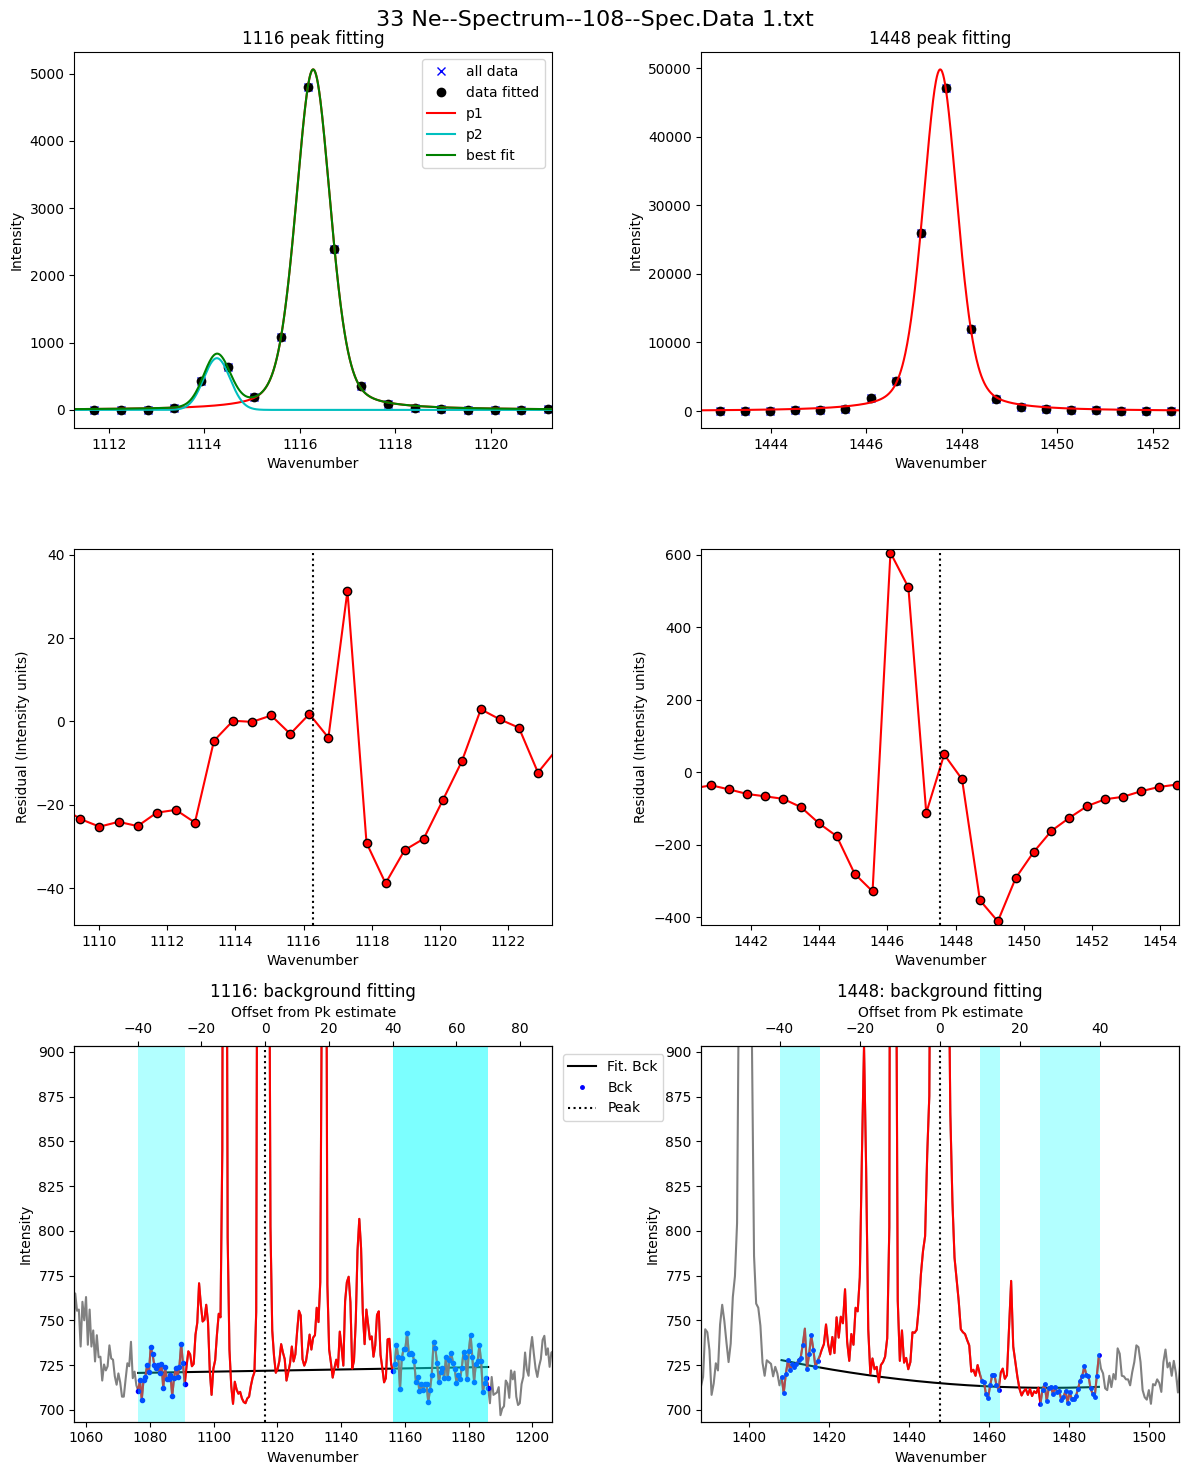

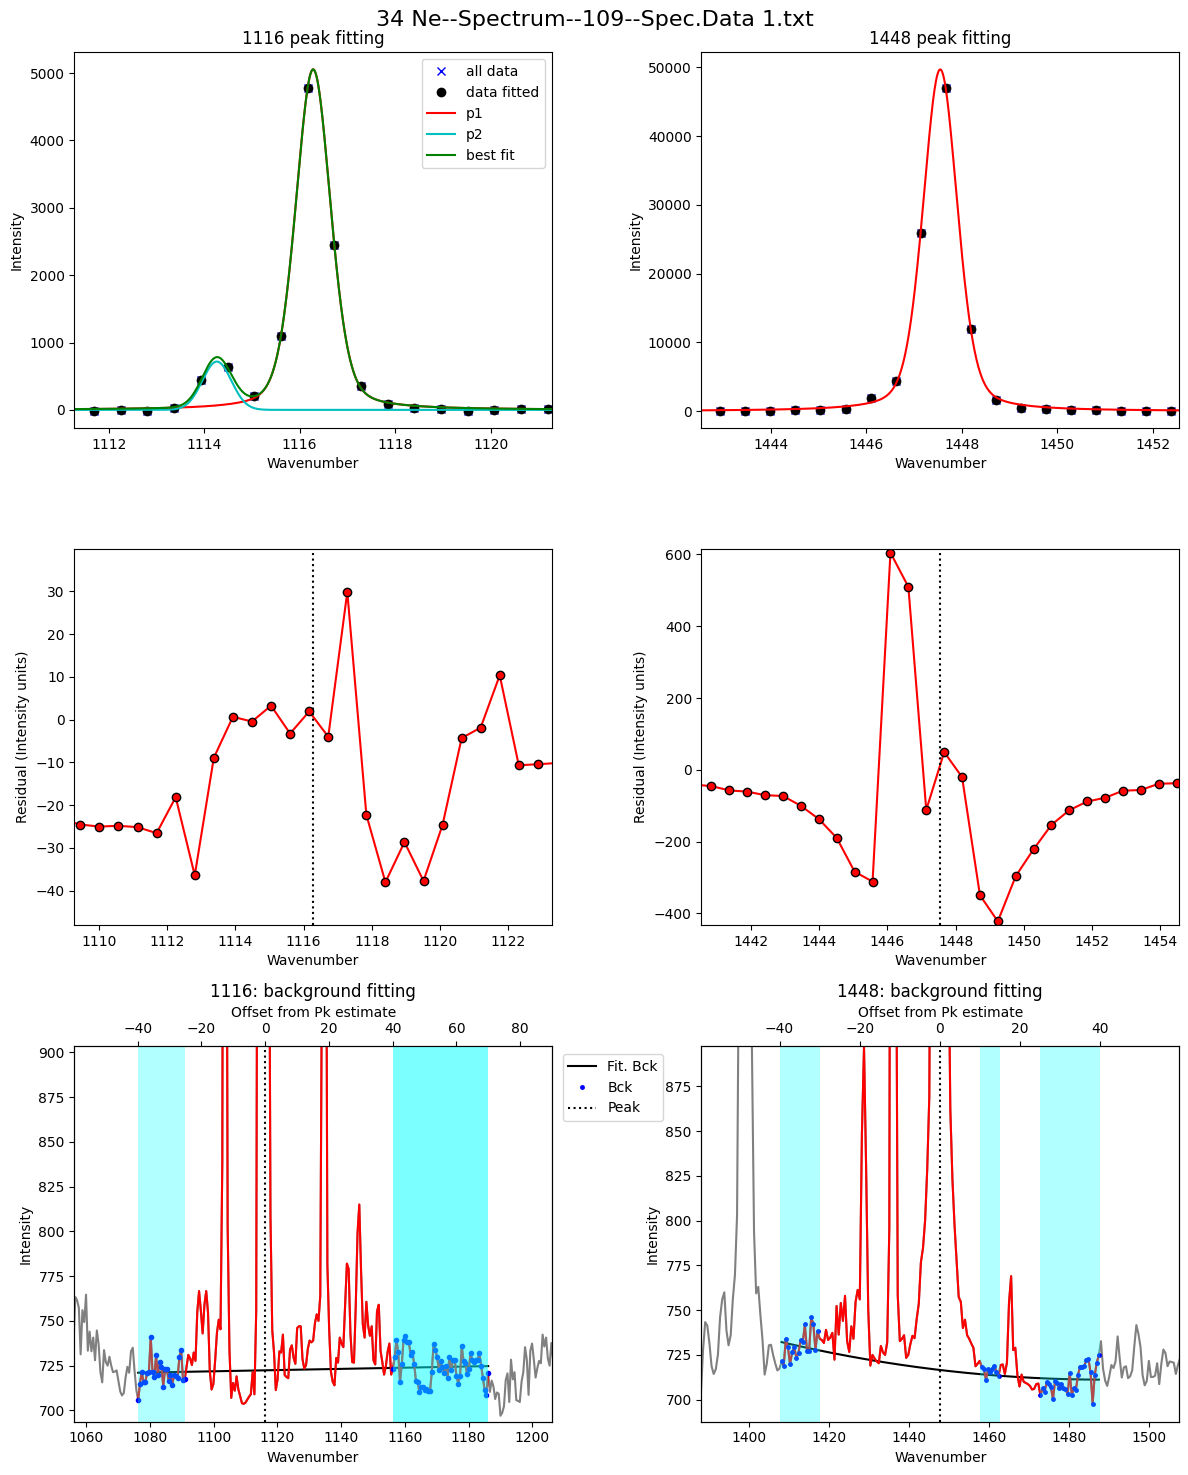

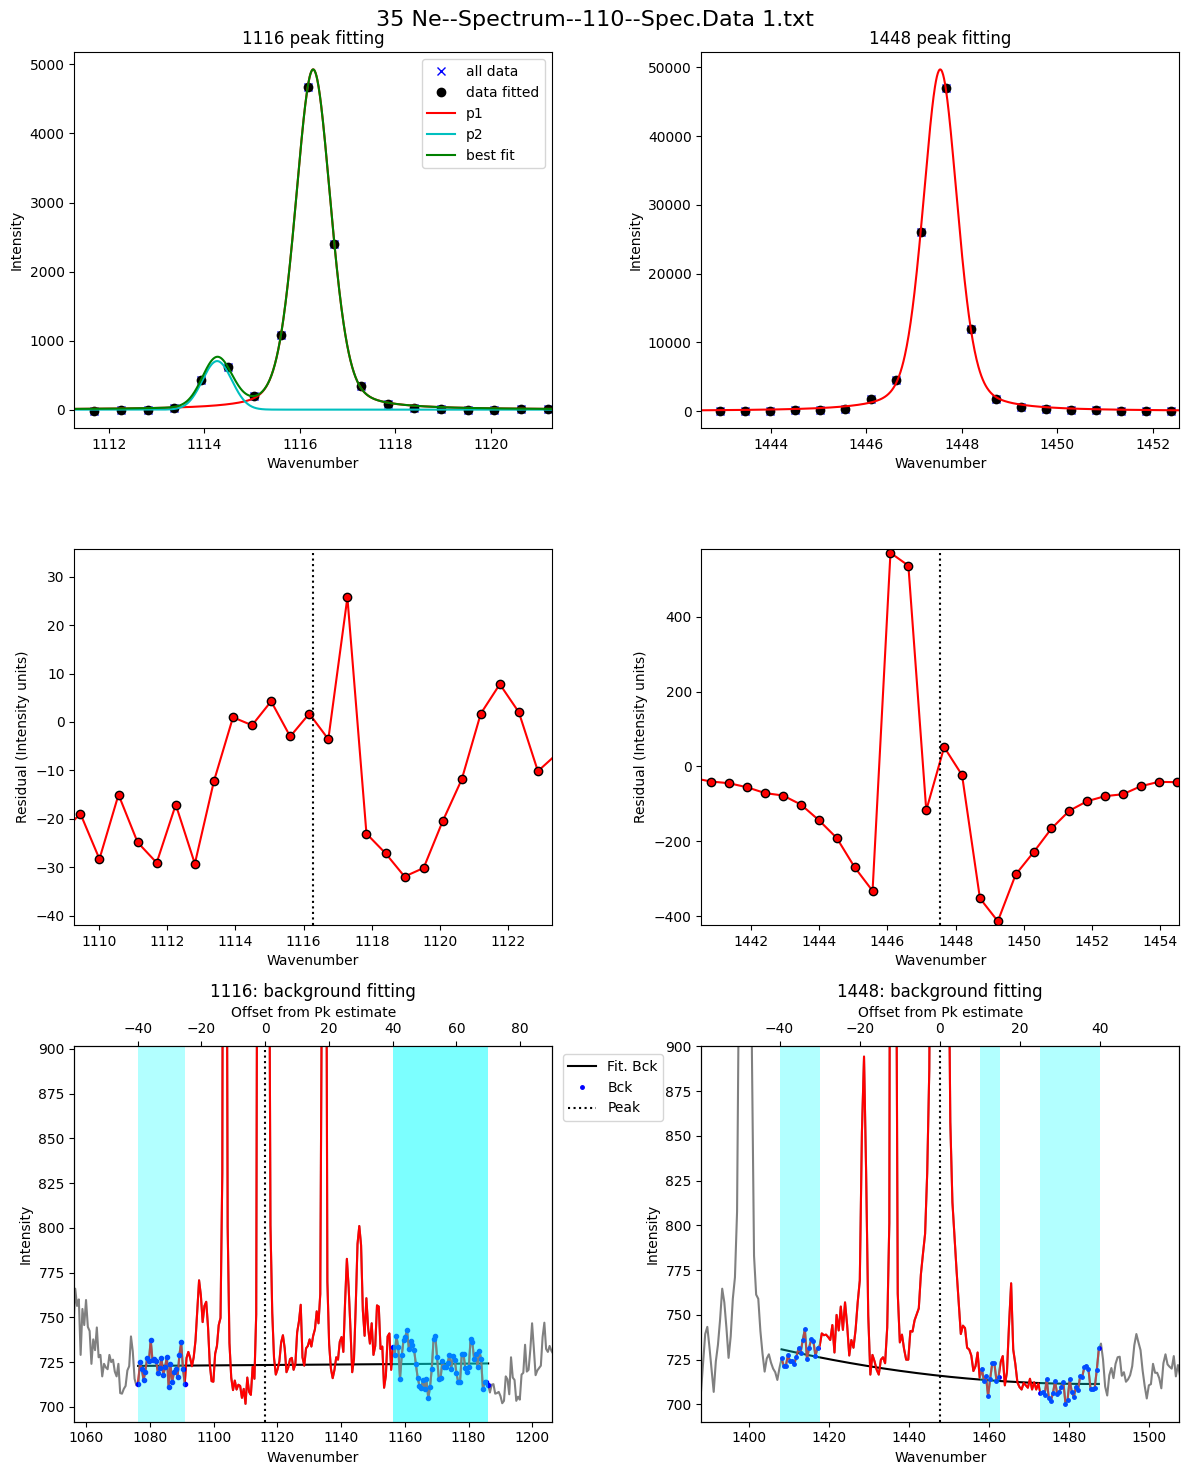

In [13]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=spectra_filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_est,
df_fit_params=df_fit_params,  prefix=prefix,                   
plot_figure=True, const_params=True)


In [26]:
df2

filename   Ne_Corr  1σ_Ne_Corr     deltaNe  \
0   Ne--Spectrum--000--Spec.Data 1.txt  0.997668    0.000035  331.250135   
1   Ne--Spectrum--001--Spec.Data 1.txt  0.997667    0.000034  331.250565   
2   Ne--Spectrum--002--Spec.Data 1.txt  0.997666    0.000036  331.250756   
3   Ne--Spectrum--023--Spec.Data 1.txt  0.997678    0.000035  331.246702   
4   Ne--Spectrum--036--Spec.Data 1.txt  0.997659    0.000037  331.253045   
5   Ne--Spectrum--058--Spec.Data 1.txt  0.997648    0.000038  331.256720   
6   Ne--Spectrum--059--Spec.Data 1.txt  0.997641    0.000037  331.259223   
7   Ne--Spectrum--075--Spec.Data 1.txt  0.997616    0.000038  331.267289   
8   Ne--Spectrum--085--Spec.Data 1.txt  0.997623    0.000037  331.265009   
9   Ne--Spectrum--108--Spec.Data 1.txt  0.997607    0.000037  331.270284   
10  Ne--Spectrum--109--Spec.Data 1.txt  0.997622    0.000037  331.265476   
11  Ne--Spectrum--110--Spec.Data 1.txt  0.997613    0.000037  331.268286   

    pk2_peak_cent  pk1_peak_cent  pk2_amplitude  pk1_amplitude  residual_pk2  \
0     1447.390790    1116.140655   51166.955860    5055.199440    103.235068   
1     1447.400539    1116.149974   51894.148837    5059.022232    131.248137   
2     1447.408339    1116.157584   52232.524521    4974.397955    104.995335   
3     1447.450214    1116.203512   54702.911740    5241.303270    121.305184   
4     1447.481782    1116.228737   54906.242240    5105.738462    117.319797   
5     1447.519681    1116.262961   54363.634873    4945.909954    119.919309   
6     1447.524123    1116.264900   53591.619390    5102.287474    124.568850   
7     1447.533528    1116.266239   53677.024005    5156.892160    122.407272   
8     1447.539018    1116.274009   53128.039058    5054.502793    125.734466   
9     1447.548538    1116.278254   51967.076607    5298.434634    124.481481   
10    1447.548078    1116.282602   51789.060326    5317.984517    124.897464   
11    1447.548342    1116.280056   51880.393645    5186.826375    125.631048   

    residual_pk1  ...  pk1_sigma  pk1_gamma error_pk1  Peak1_Prop_Lor  \
0      14.678463  ...   0.432405       None  0.011447        0.316436   
1      14.092393  ...   0.428841       None  0.011137        0.325167   
2      14.882947  ...   0.431220       None  0.011665        0.317978   
3      15.304273  ...   0.429726       None  0.011522        0.357586   
4      13.783525  ...   0.432340       None  0.012319        0.354981   
5      14.487324  ...   0.433344       None  0.012529        0.356604   
6      14.649111  ...   0.428391       None  0.012191        0.391836   
7      14.664005  ...   0.432886       None  0.012396        0.369145   
8      14.102996  ...   0.437434       None  0.012211        0.349524   
9      14.605987  ...   0.428621       None  0.012050        0.397572   
10     16.113824  ...   0.432607       None  0.012076        0.386652   
11     14.703835  ...   0.435811       None  0.012021        0.367667   

    Ne_Corr_min  Ne_Corr_max residual_pk1+pk2  error_pk1_amplitude  \
0      0.997628     0.997708       117.913531           195.889591   
1      0.997627     0.997706       145.340530           189.875458   
2      0.997626     0.997706       119.878282           196.448205   
3      0.997639     0.997718       136.609457           197.867761   
4      0.997617     0.997701       131.103322           205.248081   
5      0.997605     0.997691       134.406633           201.251924   
6      0.997599     0.997683       139.217962           196.535628   
7      0.997574     0.997659       137.071277           205.747600   
8      0.997581     0.997665       139.837463           201.893900   
9      0.997566     0.997649       139.087468           201.340554   
10     0.997580     0.997663       141.011288           204.756980   
11     0.997572     0.997655       140.334883           201.662459   

    error_pk2_amplitude  name_for_matching  
0           3673.335710  Ne--Spectrum--000  
1            643.167935  Ne--Spectrum--001  
2   

## Now extract metadata to get a timestamp for each file

In [27]:
## Get meta files
Ne_files_meta=pf.get_files(path=meta_path,
file_ext=spectra_file_ext, ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files_meta[0:5]

['01 Ne--Spectrum--000--Information.txt',
 '02 Ne--Spectrum--001--Information.txt',
 '03 Ne--Spectrum--002--Information.txt',
 '23 Ne--Spectrum--023--Information.txt',
 '36 Ne--Spectrum--036--Information.txt']

In [28]:
# This cell stitches metadata together - e.g. gets your laser power, time stamp, accumulations etc
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=Ne_files_meta, prefix=prefix, trupower=TruPower)
meta.head()

100%|██████████| 12/12 [00:00<00:00, 531.15it/s]

Done


filename              date  Month   Day  \
0  Ne--Spectrum--000--Information.txt  March 20, 2024\n  March  20.0   
1  Ne--Spectrum--001--Information.txt  March 20, 2024\n  March  20.0   
2  Ne--Spectrum--002--Information.txt  March 20, 2024\n  March  20.0   
3  Ne--Spectrum--023--Information.txt  March 20, 2024\n  March  20.0   
4  Ne--Spectrum--036--Information.txt  March 20, 2024\n  March  20.0   

   power (mW)  Int_time (s)  accumulations  Mag (X)             duration  \
0       5.955          45.0            3.0      5.0  ['0h', '2m', '19s']   
1       5.924          45.0            3.0      5.0  ['0h', '2m', '16s']   
2       5.894          45.0            3.0      5.0  ['0h', '2m', '16s']   
3       5.997          45.0            3.0    100.0  ['0h', '2m', '16s']   
4       5.899          45.0            3.0    100.0  ['0h', '2m', '16s']   

       24hr_time  sec since midnight  Spectral Center  
0  11:06:46 AM\n             40006.0         1325.004  
1  11:09:40 AM\n             40180.0         1325.004  
2  11:12:32 AM\n             40352.0         1325.004  
3  11:41:20 AM\n             42080.0         1325.004  
4  12:07:09 PM\n             43629.0         1325.004

In [29]:
# This is getting the metadata file names.  Check here the prefix has been removed. 
file_m=pf.extracting_filenames_generic(names=meta['filename'], 
   file_ext=meta_file_ext)

for i in range(len(file_m)):
    file_m[i] = file_m[i].replace("--Information", "")
file_m

good job, no duplicate file names


array(['Ne--Spectrum--000', 'Ne--Spectrum--001', 'Ne--Spectrum--002',
       'Ne--Spectrum--023', 'Ne--Spectrum--036', 'Ne--Spectrum--058',
       'Ne--Spectrum--059', 'Ne--Spectrum--075', 'Ne--Spectrum--085',
       'Ne--Spectrum--108', 'Ne--Spectrum--109', 'Ne--Spectrum--110'],
      dtype=object)

In [30]:
# This is getting the spectra file names. Check that they are in the same format as the metadataones above, this is what you need to successfully stitch together. 
file_s=pf.extracting_filenames_generic(names=df2['filename'],
   file_ext=spectra_file_ext)

for i in range(len(file_s)):
    file_s[i] = file_s[i].replace("--Spec.Data 1", "")
file_s

good job, no duplicate file names


array(['Ne--Spectrum--000', 'Ne--Spectrum--001', 'Ne--Spectrum--002',
       'Ne--Spectrum--023', 'Ne--Spectrum--036', 'Ne--Spectrum--058',
       'Ne--Spectrum--059', 'Ne--Spectrum--075', 'Ne--Spectrum--085',
       'Ne--Spectrum--108', 'Ne--Spectrum--109', 'Ne--Spectrum--110'],
      dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [31]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')
print('Number merged= '+str(len(df_combo))+', Check this is what you expected, else check file_m and file_s look the same')

Number merged= 12, Check this is what you expected, else check file_m and file_s look the same


## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [32]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

In [33]:
0.4/df_combo['error_pk2']

0     225.910206
1     210.279803
2     228.999671
3     262.292075
4     252.816957
5     240.941139
6     230.262858
7     236.011730
8     224.470742
9     225.793147
10    223.326158
11    222.560910
Name: error_pk2, dtype: float64

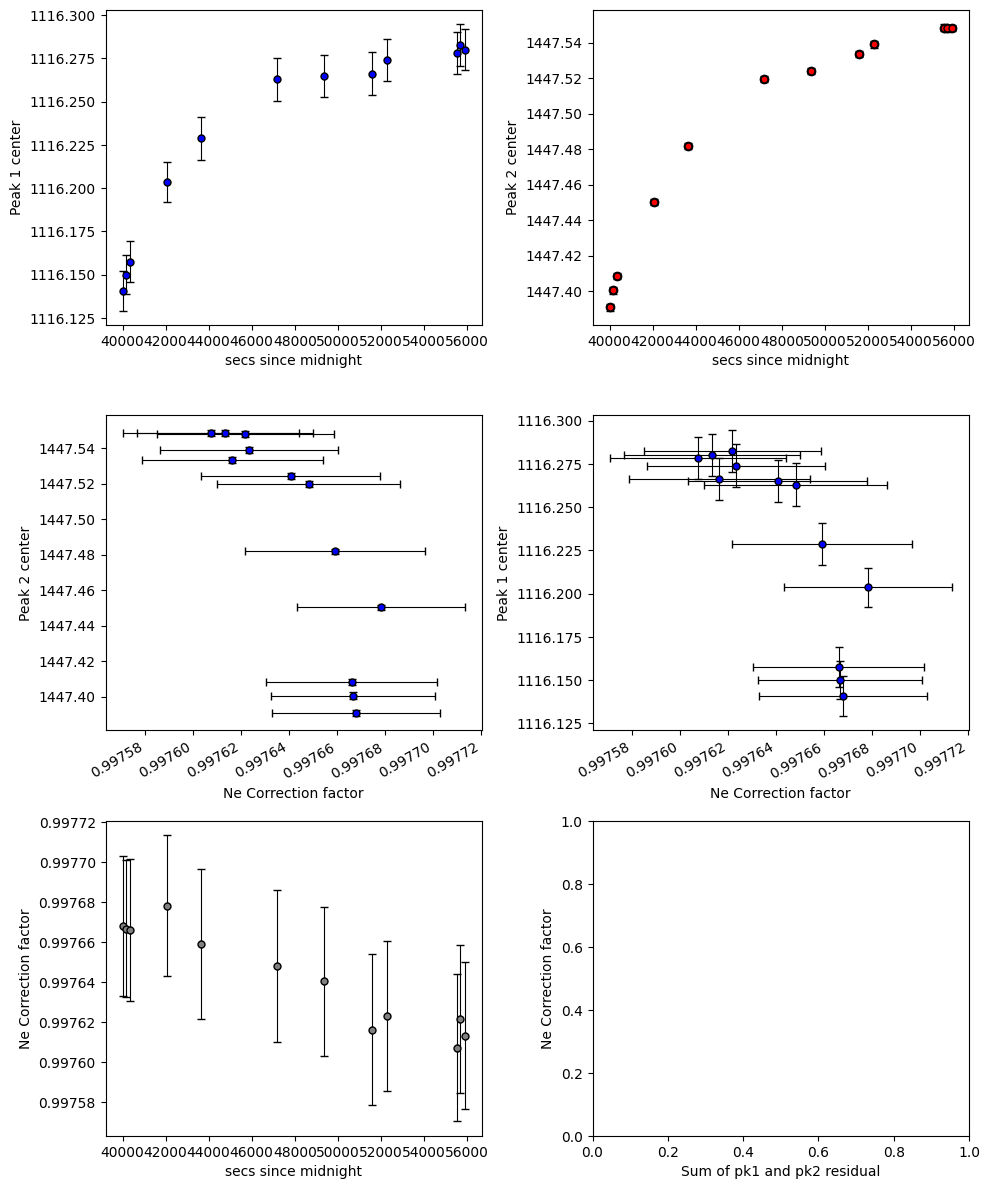

In [34]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


In [35]:
103.2*0.9979

102.98328000000001

## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right
- Smaller number of offset - more discarded
- If you notice really bad fits, you can also exclude certain files like file_name_filt=['Ne_line_1.txt'], or file_name_filt=['Ne_line_2.txt', 'Ne_line_5.txt']

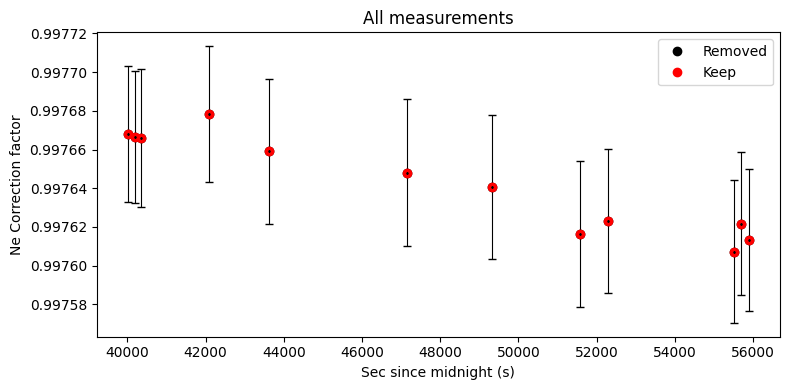

In [36]:
filt=pf.filter_Ne_Line_neighbours(df_combo=df_combo, 
                    number_av=3, offset=0.001, file_name_filt=None)
# Now lets plot this to see
fig, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.errorbar(df_combo['sec since midnight'], df_combo['Ne_Corr'], xerr=0, 
yerr=df_combo['1σ_Ne_Corr'], fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=1, mec='k', capsize=3)
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='Removed')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Keep')

ax1.legend()

ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')

fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

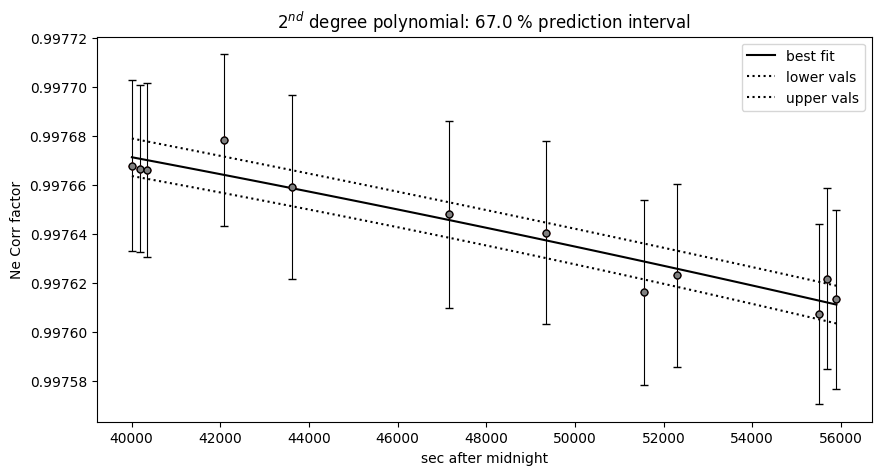

In [37]:

big_err=df_combo['1σ_Ne_Corr']>0.0001
## Lets get filtered ones
keep=(filt>0)&(~big_err)

pf.generate_Ne_corr_model(time=df_combo['sec since midnight'].loc[keep], Ne_corr=df_combo.loc[keep], 
N_poly=2, CI=0.67, pkl_name='Neon_corr_model.pkl')
